# Réseau de neurones 
Ce notebook présente plusieurs portions du code que nous avons utilisé pour entrainer notre réseau de neurones. Nous ne donnons pas tout le code, il sert plutôt d'aperçu du travail que nous avons pu effectuer. 

## Architecture du réseau de neurones 
On utilise directement Torch pour construire le code du générateur. On rappelle l'architecture du réseau de neurones que nous décrivons dans le papier : 
Ci-dessous vous trouverez son implémentation Torch.

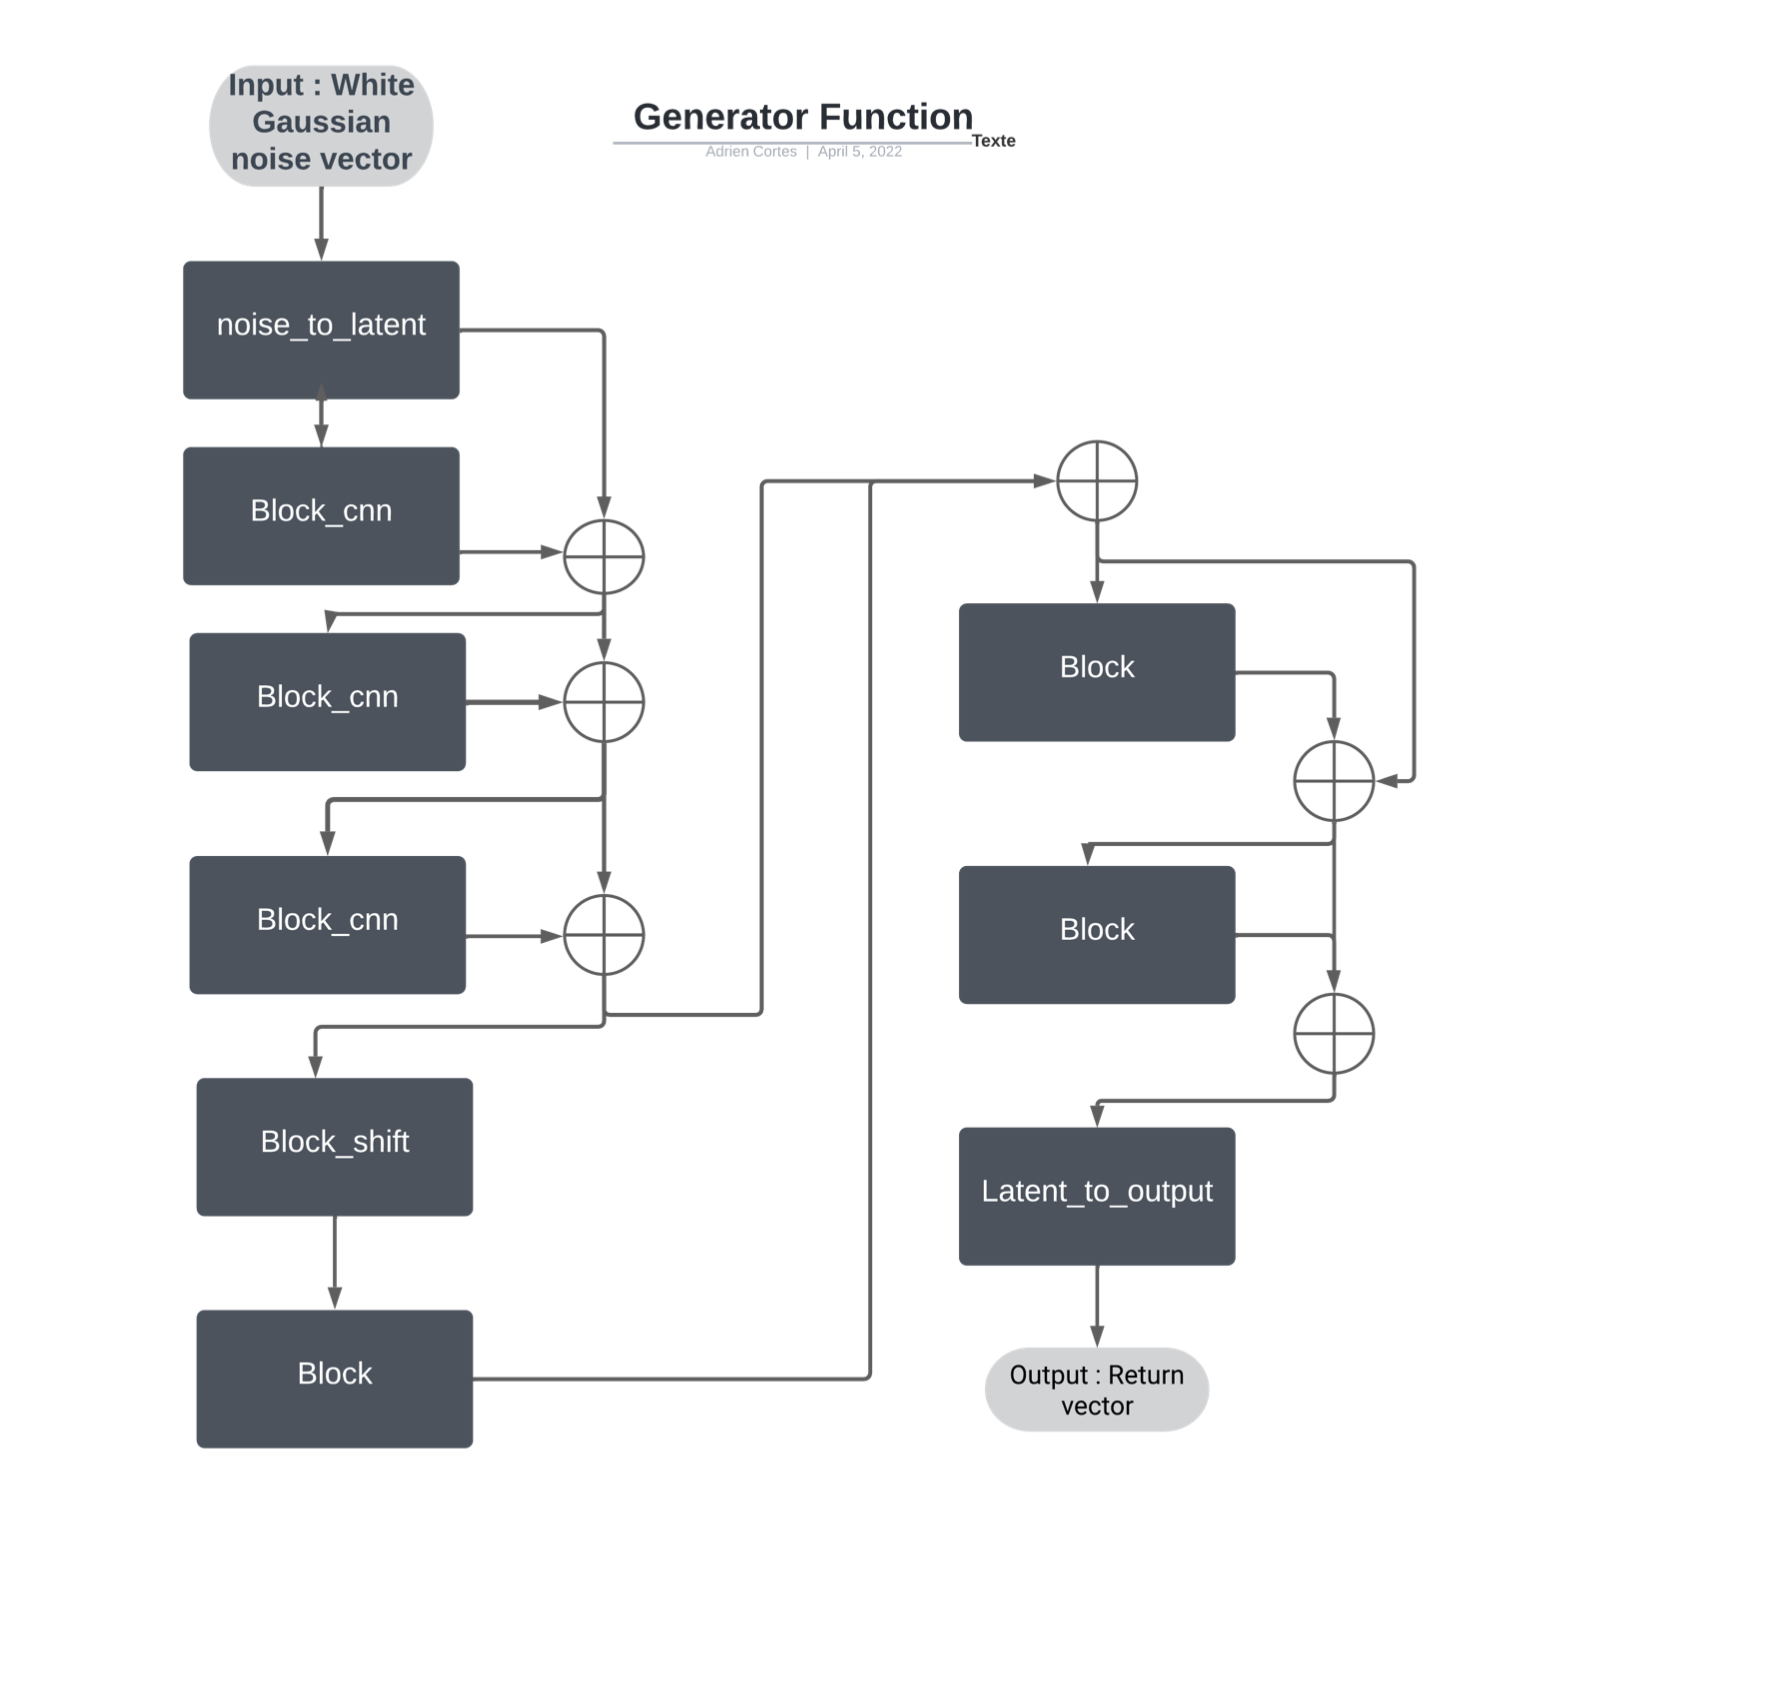

In [63]:
import torch
import torch.nn as nn
#notre générateur

class Generator(nn.Module):
    def __init__(self, latent_dim, ts_dim, condition):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.ts_dim = ts_dim
        self.condition = condition
        self.hidden = 128
        
        self.block = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
           
        )
        self.block_cnn = nn.Sequential(
            nn.Conv1d(self.hidden,self.hidden, kernel_size=3, dilation=2, padding=2),
            nn.LeakyReLU(inplace=True),
        )
        self.block_shift = nn.Sequential(
            nn.Conv1d(self.hidden,10, kernel_size=3, dilation=2, padding=2),
            nn.LeakyReLU(inplace=True),
            
            nn.Flatten(start_dim=1),
            nn.Linear(10*self.latent_dim,256),
            nn.LeakyReLU(inplace=True),
        )
        self.noise_to_latent = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.hidden, kernel_size=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(self.hidden,self.hidden, kernel_size=5, dilation=2, padding=4),
            nn.LeakyReLU(inplace=True),
        )
        self.latent_to_output = nn.Sequential(
            nn.Linear(256, self.ts_dim-self.condition),
        )

    def forward(self, input_data):
        x = self.noise_to_latent(input_data)
        x_block = self.block_cnn(x)
        x = x_block +x
        x_block = self.block_cnn(x)
        x = x_block +x
        x_block = self.block_cnn(x)
        x = x_block +x
        x = self.block_shift(x)
        x_block = self.block(x)
        x = x_block + x #torch.cat([x, x_block], 1)
        x_block = self.block(x)
        x = x_block + x #torch.cat([x, x_block], 1)
        x_block = self.block(x)
        x = x_block + x #torch.cat([x, x_block], 1)
        x = self.latent_to_output(x)
        return x[:,None,:]


# Préparation du data 
L'idée est de montrer la une portion du code de la fonction que nous avons utilisé pour préparer le réseau à l'entrainement. 

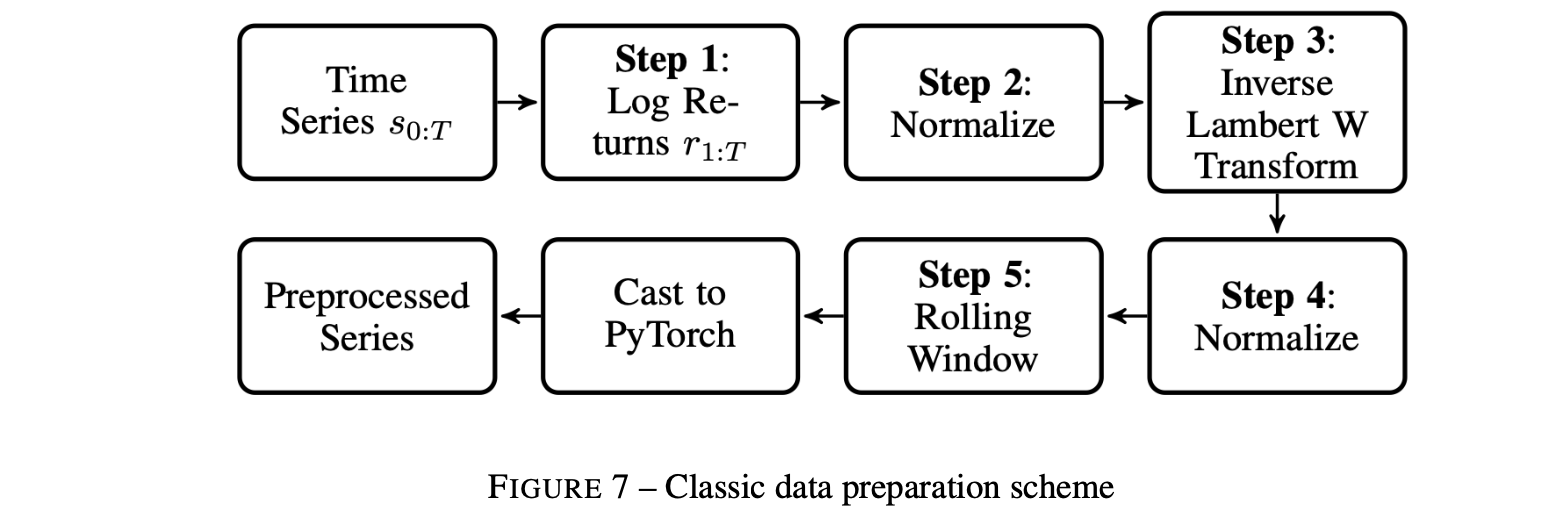
Tout est directement dans la classe Data. On présente une version simplifiée de ce que nous avons utilisé ci-dessous, pour faciliter la compréhension du lecteur : (il s'agit de notre V0 en réalité).

In [ ]:
class Preparation_data():
    def __init__(self,cloture,taille_fenetre,generator):
        self.cours_cloture = cloture #on enregistre le cours de cloture. 
        self.rendements = self.preprocessing(np.diff(self.cours_cloture))
        self.x_input = self.window(taille_fenetre,self.rendements)
        self.generator = generator
        
    def preprocessing(self,returns):
        # on va sortir les rendements normalisés. Et on va s'en servir pour le window roulant 
        out = returns.reshape((len(returns),1)) #(n,1) pour le preprocessing 
        out = scaler.fit_transform(out)
        return out.reshape((len(returns)))
    
    def post_processing(self,x):
        #on a x doit retourner du data propre ? 
    
    def window(self,taille_fenetre,x):
        #on va extraire des données d'une taille fixée 
        out = [x[i:i+taille_fenetre] for i in range(0,len(x)-taille_fenetre+1,4)]
        return out 
    
    def preparer_data(self,n):
        
        x_real = np.zeros(shape=(n,len(self.x_input[0]))) #les vrais data
        x_fake = np.zeros(shape=(n,len(self.x_input[0]))) #les faux data 
      
        for i in range(n):
            
            
            x_real[i] = self.x_input[np.random.randint(0,len(self.x_input)-1)]
            x_fake[i] = np.squeeze(self.generator(torch.rand(1,1,len(self.x_input[0]))).detach().numpy())
        
        return torch.reshape(torch.tensor(x_real),[n,1,len(self.x_input[0])]).clone().to(torch.float32),torch.reshape(torch.tensor(x_fake),[n,1,len(self.x_input[0])]).clone().to(torch.float32)

# Entrainement 
Comme nous l'avons dit, l'entrainement se fait entre le générateur et un discriminateur (que l'on ne détaille pas ici). On montre cependant l'idée du code :
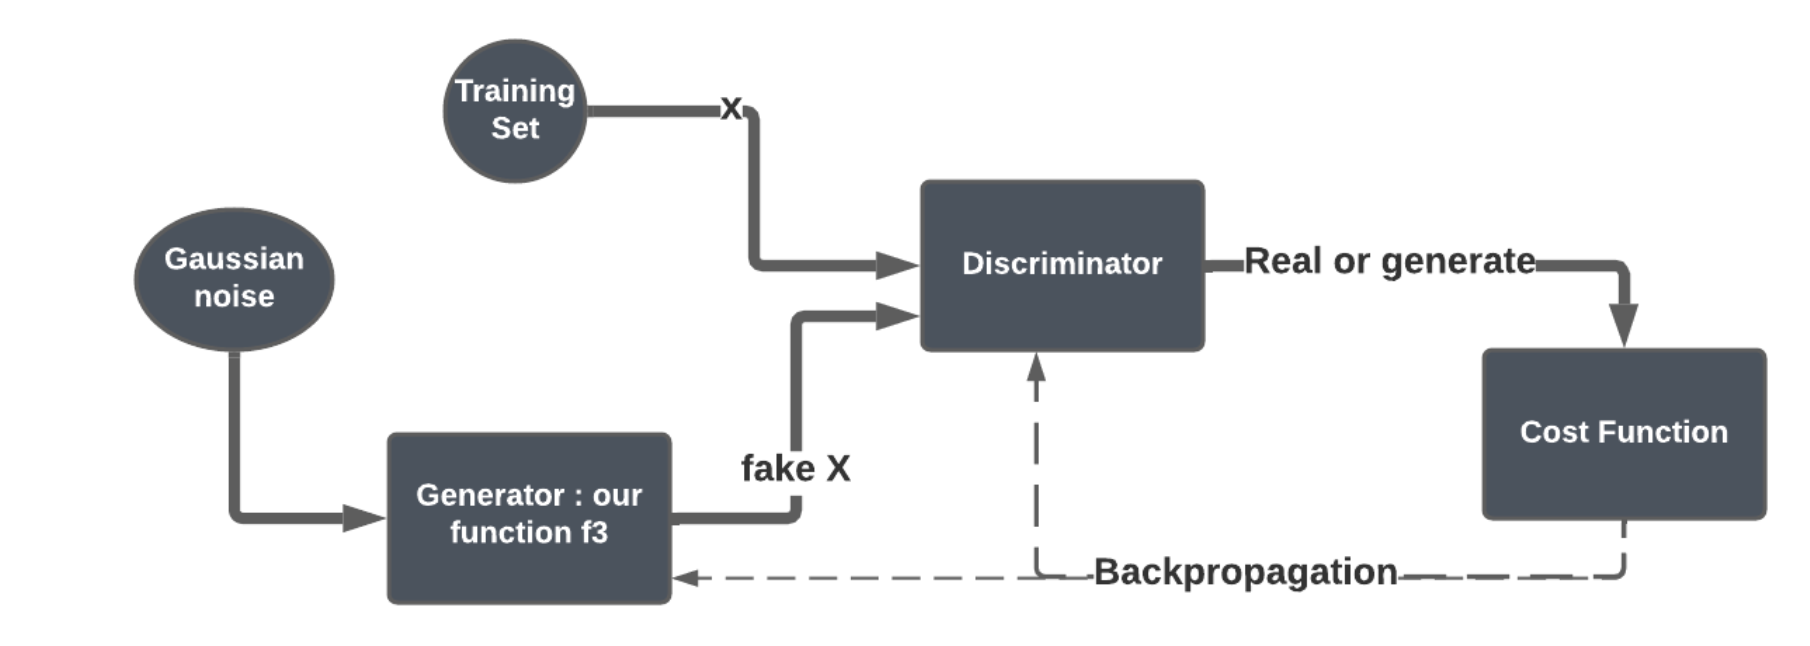

Au fur et à mesure du temps, le code est devenu relativement compliqué pour être simple à lire au lecteu. Cependant, on donne une version simple ci-dessous, sans la pénlité pour le gradient. 

In [ ]:
discriminator  = Discriminator(1,80,1,400) #on prend des séries de taille 40 
generator = Generator(1,80,1) #le générateur que l'on va utiliser, toujours taille 400 
dataset_generator = Preparation_data(close[8000:],400,generator)
#on va entrainer 10 fois le discrimiateur avant d'entrainer le générateur 
batch_size=30
lr = 4e-3
optimizer_discriminator = getattr(optim,'Adam')(discriminator.parameters(),lr=lr) #optimizer pour le discriminateur...
optimizer_generator = getattr(optim,'Adam')(generator.parameters(),lr=lr) #optimizer pour le générateur... 

def train(epoch):
    batch_idx = 0 #index du batch 
    total_loss = 0 #perte totale 
    for _ in range(epoch):
      
    
    
        #on génère 100 trajectoires par exemple 

        #on va commencer par entrainer tranquillement le discriminateur : 
        for _ in range(1):
            dataset_generator = Preparation_data(close,400,generator)
            x_train, y_train = dataset_generator.preparer_data(30)
            #on entraine 7 fois le disciminateur pour 1 entrainement du générateur 
            x_train_disc = discriminator(x_train)
            y_train_disc = discriminator(y_train)
            
            optimizer_discriminator.zero_grad() #on nettoie le gradient 
            loss_d = -(torch.log(x_train_disc)).mean()-(torch.log(1-y_train_disc)).mean() #on veut minimiser cette fonction ici
            
            print("la perte pour l'entrainement ", batch_idx ,"est de ",loss_d)
            loss_d.backward() #on met les poids à jour 
            optimizer_discriminator.step() #et on modifie les poids 
            
            
        dataset_generator = Preparation_data(close,400,generator)
        x_train, y_train = dataset_generator.preparer_data(30) #on génère 100 trajectoires par exemple 
        
        y_train_disc_bis = discriminator(y_train)
        
        optimizer_generator.zero_grad() #on nettoie le générateur (son optimisateur)
        loss_g = -(torch.log(y_train_disc_bis)).mean() #on veut que le fake soit le plus grand possible
        print("la perte du générateur :",loss_g)
        loss_g.backward()
        optimizer_generator.step()
        
        batch_idx+=1
        
        

    #on est capable de modifier les poids 
    

# Analyse de résultats 
Lorsque l'on remet tous ces éléments ensemble, et que l'on entraine le réseau, chose que l'on a fait séparément, on peut utiliser le réseau de neurones. On met ci-dessous les réalisations. 

In [43]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import data

In [44]:
data = data.Data(100, "apple.csv")

(2325, 100)


In [45]:
PATH = "state_dict_model.pt"
model = torch.load(PATH) #on charge le réseau de neurones premièrement entrainé 

In [46]:
def generator_return_func():
    """La fonction renvoie un return généré par le réseau"""
    noise = torch.randn((1,1,100))
    return np.squeeze(model(noise)).detach().numpy()

In [47]:
def generator_return_focus(noise):
    """La fonction renvoie un return généré par le réseau"""
    
    return np.squeeze(model(noise)).detach().numpy()

In [48]:
def simuler_cours_apple(p0):
    """p0 : prix de départ 
    La fonction prend un prix de départ et renvoie les cours de Apple (240 cours), à partir du prix initial"""
    return data.post_processing(generator_return_func(),p0)

In [49]:
def simuler_cours_apple_focus(p0,noise):
    """p0 : prix de départ 
    La fonction prend un prix de départ et renvoie les cours de Apple (240 cours), à partir du prix initial"""
    return data.post_processing(generator_return_focus(noise),p0)

In [50]:
def obtenir_traj_reelle():
    out = data.get_single_sample()
    out = data.post_processing(np.squeeze(out[0]).numpy(),out[1])
    return out

# Exemple 

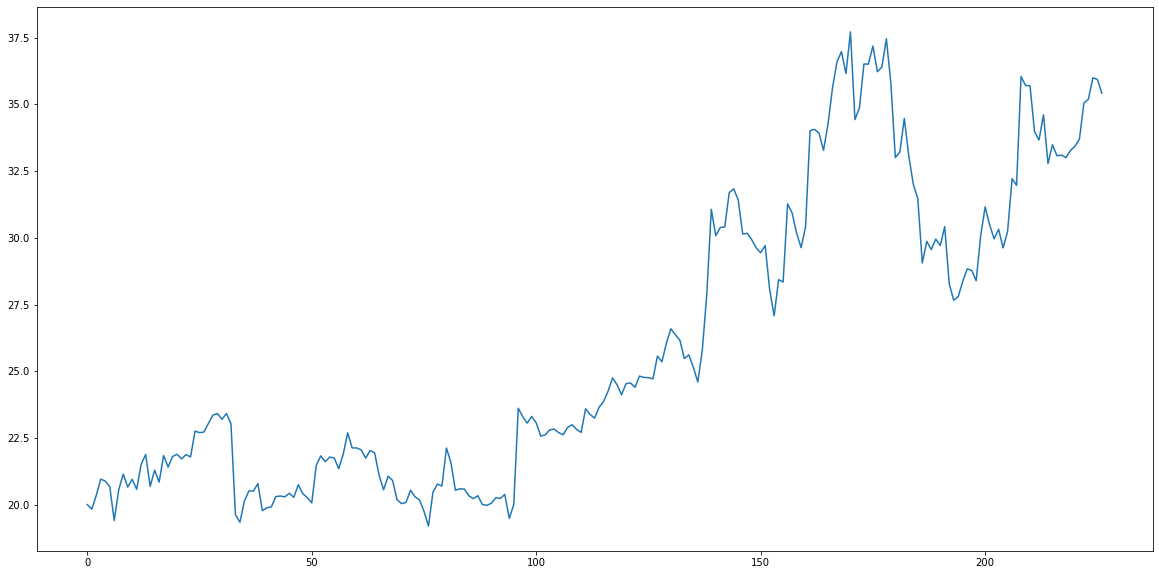

In [62]:
plt.figure(figsize=(20,10))
plt.plot(simuler_cours_apple(20))

## Visulalisation de la déformation des trajectoires 

<AxesSubplot:>

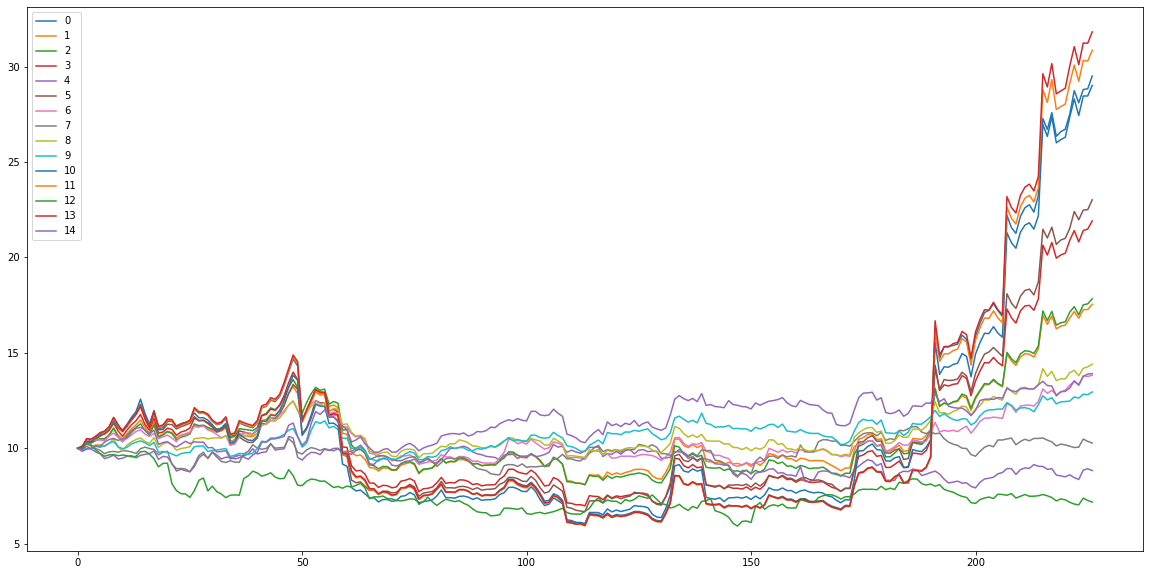

In [30]:
df = pd.DataFrame()
noise = torch.randn((1,1,100))
for i in range(15):
    noise2 = noise
    noise2[:,:,-10:] = torch.randn((1,1,10))
    df[i] = simuler_cours_apple_focus(10,noise2)
df.plot(figsize=(20,10))

<AxesSubplot:>

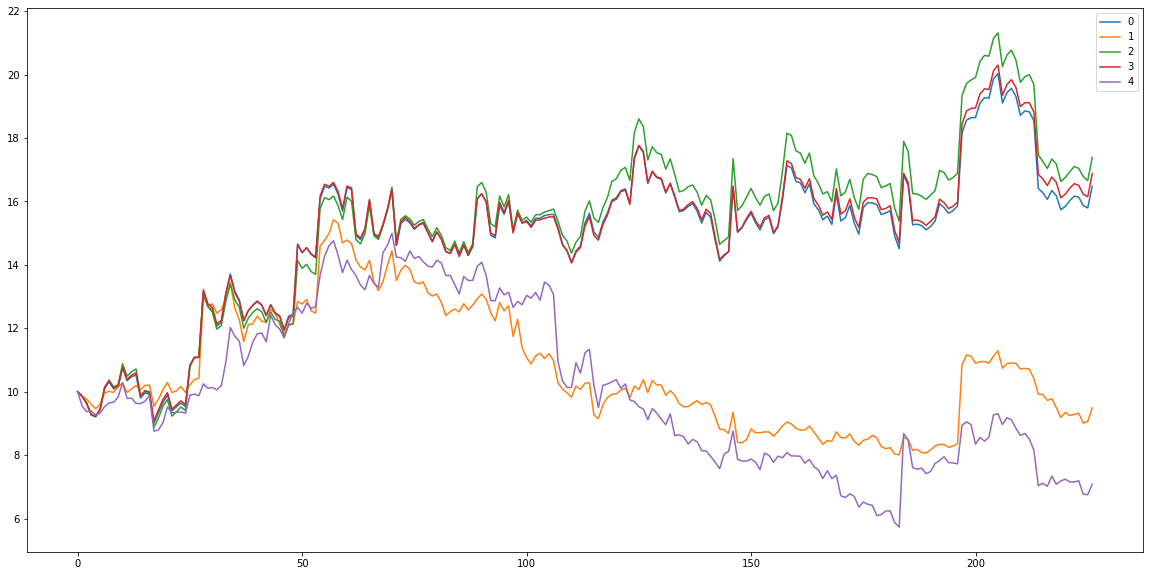

In [38]:
df = pd.DataFrame()
noise = torch.randn((1,1,100))
for i in range(5):
    noise2 = noise
    noise2[:,:,-10:] = torch.randn((1,1,10))
    df[i] = simuler_cours_apple_focus(10,noise2)
itv_conf = pd.DataFrame()
#itv_conf['itv_sup']= df.mean(axis=1) + 1.96*df.var(axis=1)
#itv_conf['itv_inf']= df.mean(axis=1) - 1.96*df.var(axis=1)
#itv_conf['mean']= df.mean(axis=1)

#itv_conf.plot(figsize=(20,10))
df.plot(figsize=(20,10))

# Analyses 
On peut vérifier que les rendements ne sont pas totalement indépendants 

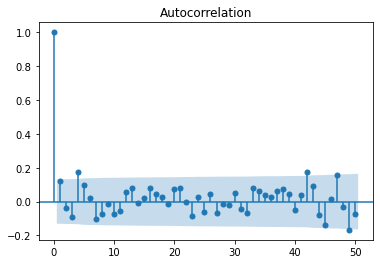

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(x=np.diff(simuler_cours_apple(100)), lags=50)
# Show the AR as a plot
plt.show()


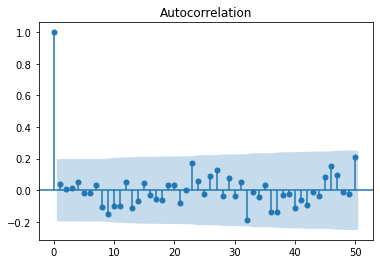

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(x=np.diff(obtenir_traj_reelle()), lags=50)
# Show the AR as a plot
plt.show()



In [41]:
from scipy.stats import kurtosis
from scipy.stats import skew

test = simuler_cours_apple(100)
print("\n On a sur le réseau de neurones que : ")
print("la symétrie est de :",skew(test, bias=False)) #symétrie 
print("l'épaisseur de la queue est :", kurtosis(test, bias=False))


print("\n 0n a sur ds cours réels que : ")
real = obtenir_traj_reelle()
print("la symétrie est de :",skew(real, bias=False)) #symétrie 
print("l'épaisseur de la queue est :", kurtosis(real, bias=False))


 On a sur le réseau de neurones que : 
la symétrie est de : 1.2213402508246316
l'épaisseur de la queue est : 2.703769569379311

 0n a sur ds cours réels que : 
la symétrie est de : 0.5230126447286726
l'épaisseur de la queue est : -0.7589189689170599
